Reserach for:
1) P000M015 Research Project 3 course at Kaunas university of technology, study programme - Applied Mathematics MSc.  
2) Research Council of Lithuania funded student research in their free time “Development and application of machine learning methods in assessing the risk of mortality of prostate cancer patients” (P-ST-22-28). (2022-2023).
  
Project github repo - https://github.com/vytautas9/Tiriamasis_Projektas_3
  
Author:  
Vytautas Kraujalis  
- LinkedIn - https://www.linkedin.com/in/vytautaskraujalis/  
- Email - vytautas.kraujalis2@gmail.com

### References

In [1]:
# Refernces
# https://www.mdpi.com/2072-6694/13/10/2453

# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html -- paziuret sita
# https://andrewpwheeler.com/2020/09/26/discrete-time-survival-models-in-python/
# https://github.com/apwheele/Blog_Code/blob/master/Python/Discrete_Time/00_PrepData.py
# https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-022-01679-6 -- rimtas sitas


# pasiskaityt, gal i duomenis pridet "Restricted cubic splines function"
# https://towardsdatascience.com/restricted-cubic-splines-c0617b07b9a5
# https://github.com/apwheele/Blog_Code/tree/master/Python/Smooth
# https://andrewpwheeler.com/2020/09/20/making-smoothed-scatterplots-in-python/

### Modules

In [23]:
# Modules
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tableone import TableOne # for the descriptive table
from matplotlib import pyplot as plt

### Functions
Functions, which will be used later in the project

In [54]:
def read_prepare_initial_data(path):
    # Read, prepare, anonimize the initial data
    df = pd.read_sas(path)
    
    # Select only relevant columns
    df = df[['Amzius', 'PSA', 'naujasCT', 'BxGleason', 'Bxkodas', 'RP_GG', 'pT', 
             'LNI01', 'R', 'PSAdaugiau0_1', 'BCR', 'MTS', 'SURVIVAL', 'OS', 'CSS',
             'Rpgleson', 'TRYSgrupes', 'PLNDO1']]
    
    # Create survival column in years
    #df["survival_years"] = df["SURVIVAL"] / 12
    
    # Rename the column names
    df.rename(columns = {'Amzius': 'age', 'PSA': 'psa', 'naujasCT': 'clinical_stage', 
                         'Bxkodas': 'biopsy_gleason_gg', 'RP_GG': 'pathological_gleason_gg',
                         'pT': 'pathologic_stage', 'LNI01': 'lni', 'R': 'surgical_margin_status', 
                         'PSAdaugiau0_1': 'persistent_psa', 'SURVIVAL': 'survival_months', 
                         'BCR': 'bcr', 'MTS': 'mts', 'OS': 'overall_mortality', 
                         'CSS': 'cancer_specific_mortality'}, 
               inplace = True)
    
    # Fill the LNI column NA values with 'unknown' value
    df.fillna({'lni': 'unknown', 'r': 'unknown'}, inplace = True)
    
    # Drop rows with NA values, every row must have 0 NA values
    df.dropna(thresh=df.shape[1], inplace = True)
    
    # Change the data types of columns
    # Float --> Int --> String
    df[['overall_mortality']] = df[['overall_mortality']].astype(int)
    df[['cancer_specific_mortality']] = df[['cancer_specific_mortality']].astype(int)
    df[['mts']] = df[['mts']].astype(int)
    df[['bcr']] = df[['bcr']].astype(int)
    df[['clinical_stage']] = df[['clinical_stage']].astype(int)
    df[['biopsy_gleason_gg']] = df[['biopsy_gleason_gg']].astype(int)
    df[['pathological_gleason_gg']] = df[['pathological_gleason_gg']].astype(int)
    df[['pathologic_stage']] = df[['pathologic_stage']].astype(int)
    df[['surgical_margin_status']] = df[['surgical_margin_status']].astype(int)
    df[['persistent_psa']] = df[['persistent_psa']].astype(int)
    df[['TRYSgrupes']] = df[['TRYSgrupes']].astype(int)
    df[['PLNDO1']] = df[['PLNDO1']].astype(int)
    
    df = df.astype({'clinical_stage': 'str', 'biopsy_gleason_gg': 'str', 
                    'pathological_gleason_gg': 'str', 'pathologic_stage': 'str',
                    'lni': 'str', 'surgical_margin_status': 'str', 
                    'persistent_psa': 'str', 'bcr': 'str', 'mts': 'str', 
                    'overall_mortality': 'str', 'cancer_specific_mortality': 'str', 
                    'TRYSgrupes': 'str', 'PLNDO1': 'str',
                    'survival_months': 'int32'}) 
    
    # Create death from other causes column
    df['death_from_other_causes'] = '0'
    df.loc[(df['overall_mortality'] == '1') & (df['cancer_specific_mortality'] == '0'), 'death_from_other_causes'] = '1'
    
    # Create a patient ID index
    df['patient_id'] = range(1, len(df) + 1)
    
    return df


# Explodes the provided data based on survival column
def explode_data(df,max_time,min_time=1,time='survival_months',
                 time_discrete='survival_time_discrete',cum_event=False):
    # We create a new time column and clip the data by provided min and max survival times
    df[time_discrete] = df[time].clip(min_time,max_time).apply(range)

    # Exploding the dataset with the created range value in new time column
    data_exploded = df.explode(time_discrete)

    # Reset index
    data_exploded.reset_index(drop=True, inplace=True)

    # New column starts at 0, we'll increase each value by 1
    data_exploded[time_discrete] = pd.to_numeric(data_exploded[time_discrete]) + 1

    # New event column, which will indicate the last event date
    data_exploded['cancer_specific_mortality_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['cancer_specific_mortality'])
    data_exploded['death_from_other_causes_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['death_from_other_causes'])
    data_exploded['mts_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['mts'])
    data_exploded['bcr_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['bcr'])
    
    if cum_event == True:
        # Create new event column with duplicated event values from discrete column
        data_exploded['cancer_specific_mortality_cumulative'] = data_exploded['cancer_specific_mortality_discrete']
        data_exploded['death_from_other_causes_cumulative'] = data_exploded['death_from_other_causes_discrete']
        data_exploded['mts_cumulative'] = data_exploded['mts_discrete']
        data_exploded['bcr_cumulative'] = data_exploded['bcr_discrete']
        
        after_survival_time = data_exploded[time_discrete] > data_exploded[time]
        
        # For cumulative events, after end_time we will have NA values, we'll replace those with event indicator
        discrete_column = ['cancer_specific_mortality_discrete', 'death_from_other_causes_discrete', 'mts_discrete', 'bcr_discrete']
        cumulative_column = ['cancer_specific_mortality_cumulative', 'death_from_other_causes_cumulative', 'mts_cumulative', 'bcr_cumulative']
        data_exploded.loc[after_survival_time, discrete_column] = -1
        data_exploded[discrete_column] = data_exploded[discrete_column].replace(-1,np.NaN)
        data_exploded.loc[(after_survival_time & (data_exploded['cancer_specific_mortality']==0)), 'cancer_specific_mortality_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['death_from_other_causes']==0)), 'death_from_other_causes_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['mts']==0)), 'mts_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['bcr']==0)), 'bcr_cumulative'] = -1
        data_exploded[cumulative_column] = data_exploded[cumulative_column].replace(-1,np.NaN)
    return data_exploded


# Create dummy variables, split the data into train and test
def split_and_prepare_data(df, x_columns_to_drop, y_columns):
    
    # Create dummy variables for categorical data
    df = pd.get_dummies(df, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                    'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                    'TRYSgrupes', 'PLNDO1'])
    df_train, df_test, y_train, y_test = train_test_split(
        df.drop(x_columns_to_drop, axis=1),
        df[y_columns], test_size=0.20, random_state=1, stratify=df[['overall_mortality']])
    
    df_train[y_columns] = y_train
    df_test[y_columns] = y_test
    
    return df_train, df_test


# Cumulative hazard based on predicted probabilities, for instant time points.
# Can be grouped by patients
def cumulative_hazard(df, event_probability_column, id_column):
    data_copy = df.copy()
    if id_column is not None:
        data_copy = data_copy[ [id_column, event_probability_column] ]
    else:
        data_copy = data_copy[ [event_probability_column] ]
    data_copy['negative_log_prob'] = np.log( 1 - data_copy[event_probability_column] )
    if id_column is not None:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy.groupby(id_column)['negative_log_prob'].transform(pd.Series.cumsum))
    else:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy['negative_log_prob'].cumsum())
    return data_copy['cumulative_hazard']


# Train the model based on training data.
# Before training, explode the data with given maximum time and save the model
def train_model(model, df_train, target_column, max_time, min_time=1, x_columns_to_drop=None):
    df_train_copy = df_train.copy()
    
    # Extract model name
    model_name = type(model).__name__
    print(f'Experiment with {model_name}:')
    print(f'\tStarting fitting a {model_name} model...')
    
    # Explode the dataset
    df_train_copy_exploded = explode_data(df_train_copy, max_time=max_time)
    
    # Drop columns/targets from feature set
    if x_columns_to_drop is not None:
        X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)
    else:    
        X_train = df_train_copy_exploded.drop(target_column, axis=1)
        
    y_train = df_train_copy_exploded[target_column]
    
    # Fit model to training data
    model.fit(X_train, y_train)
    print(f'\tFinished fitting.')

    # Save model
    model_path = f'results/{target_column}/{max_time}/{model_name}'
    print(f'\tSaving results to "{model_path}"...')
    # Create directory if does not exist
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    with open(f'{model_path}/model.sav', 'wb') as f:
        pickle.dump(model, f)
    print(f'\tFinished saving reults.')
    
    return model


# Given non exploded dataset, explode the dataset based on maximum time
# and add predicted instant mortality probabilities and also cumulative.
# Returns exploded dataset with probabilities
def add_predict_probabilities(df, model, max_time, target_column):
    df_exploded = explode_data(df, max_time=max_time, min_time=max_time, cum_event=True)

    # List of columns names which will be dropped from feature set before predicting outcome
    x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                         'death_from_other_causes', 'cancer_specific_mortality',
                         'death_from_other_causes_discrete', 'mts_discrete',
                         'bcr_discrete', 'cancer_specific_mortality_discrete',
                         'cancer_specific_mortality_cumulative',
                         'death_from_other_causes_cumulative', 'mts_cumulative',
                         'bcr_cumulative']

    X_df = df_exploded.drop(x_columns_to_drop, axis=1)
    #y_df = df_exploded[target_column]

    # probabilities
    y_pred = model.predict_proba(X_df)[:,1]
    df_exploded['mortality_instant_prob'] = y_pred

    # Cumulative hazard for each patient
    df_exploded['cumulative_hazard'] = cumulative_hazard(df_exploded,'mortality_instant_prob','patient_id')
    
    return df_exploded


# Given exploded dataset, id of a patient and a target column plots cumulative and
# instant mortality plots of the given patient
def plot_single_patient(df, patient_id, target_column, target_title='Mortality', fix_axis=True):
    if patient_id not in df['patient_id'].values:
        print(f'Patient {patient_id} is not in the dataset.')
        return
    
    # Subset of data for the given patient
    person = df[df['patient_id'] == patient_id]
    
    # Get the column indexes of required columns
    mortality_column_index = person.columns.get_loc(target_column)
    survival_column_index = person.columns.get_loc('survival_months')
    max_time_value = person.survival_time_discrete.max()
    
    # Extract model name
    model_name = type(model).__name__
    model_path = f'results/{target_column + "_discrete"}/{max_time_value}/{model_name}'
    
    # Plot cumulative mortality of the given patient
    fig, ax = plt.subplots()
    ax.plot(person['survival_time_discrete'],person['cumulative_hazard'],
            alpha=0.6,color='k',drawstyle='steps-post')
    # Add line when the patient actually died
    if person.iloc[0,mortality_column_index] == '1' and person.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    ax.set_xlabel('Months')
    ax.set_ylabel('Cumulative Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}')
    plt.savefig(f'{model_path}/cumulative_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()

    # Plot instant mortality of the given patient
    fig, ax = plt.subplots()
    ax.plot(person['survival_time_discrete'],person['mortality_instant_prob'],
            alpha=0.6,color='k')
    ax.set_xlabel('Months')
    ax.set_ylabel('Instant Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}')
    plt.savefig(f'{model_path}/instant_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()


# TODO
def run_experiment(df_train, df_test, model, max_time, target_column):
    # List of columns names which will be dropped from feature set before fitting the model
    x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                         'death_from_other_causes', 'cancer_specific_mortality',
                         'death_from_other_causes_discrete', 'mts_discrete',
                         'bcr_discrete', 'cancer_specific_mortality_discrete']
    
    model = train_model(model=model, df_train=df_train, target_column=target_column+'_discrete',
                   max_time=max_time, x_columns_to_drop=x_columns_to_drop)
    
    # Test on training data
    df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                     target_column=target_column)
    
    # Test on testing data
    df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                    target_column=target_column)
    
    # AUC for each cumulative slice
    # Months at which we'll check the AUC's
    months = list(range(6, max_time, 6))

    train_auc_stats = []
    test_auc_stats = []
    for month in months:
        # --- Training data ---
        # Selecting a subset of data based on the months
        select = (df_train_predicted['survival_time_discrete'] == month) & pd.notna(df_train_predicted[target_column+'_cumulative'])
        sub_dat = df_train_predicted[select]

        # If in the sliced data there's a event, calculate AUC metric,
        # otherwise assign NaN value
        if sub_dat[target_column+'_cumulative'].max() == 1:
            fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
            auc_stat = auc(fpr, tpr)
        else:
            auc_stat = float('NaN')
        train_auc_stats.append(auc_stat)

        # --- Testing data ---
        # Selecting a subset of data based on the months
        select = (df_test_predicted['survival_time_discrete'] == month) & pd.notna(df_test_predicted[target_column+'_cumulative'])
        sub_dat = df_test_predicted[select]

        # If in the sliced data there's a event, calculate AUC metric,
        # otherwise assign NaN value
        if sub_dat[target_column+'_cumulative'].max() == 1:
            fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
            auc_stat = auc(fpr, tpr)
        else:
            auc_stat = float('NaN')
        test_auc_stats.append(auc_stat)

    auc_stats = pd.DataFrame(zip(months, train_auc_stats, test_auc_stats),
                             columns=['month', 'train_auc', 'test_auc'])
    
    # Save the auc statistics
    model_name = type(model).__name__
    with open(f'results/{target_column+"_discrete"}/{max_time}/{model_name}/auc_statistics.pkl', 'wb') as f:
        pickle.dump(auc_stats, f)
    
    
def read_experiment(model_name, target_column, max_time):
    model_path = f'results/{target_column+"_discrete"}/{max_time}/{model_name}'
        
    # Read model
    with open(f'{model_path}/model.sav', 'rb') as f:
        model = pickle.load(f)
    
    # Read auc statistic
    with open(f'{model_path}/auc_statistics.pkl', 'rb') as f:
        auc_stats = pickle.load(f)
    return model, auc_stats

## Main program

In [585]:
# Read the original data
data_path = 'Data/persistentpsa_3.sas7bdat'
data = read_prepare_initial_data(data_path)
with open('Data/project_3_data_prepared.pkl', 'wb') as f:
    pickle.dump(data, f)

# Read already prepared and saved data
#with open('Data/project_3_data_prepared.pkl', 'rb') as f:
#    data = pickle.load(f)

In [586]:
# Explore the original data
print('Original data shape: ', data.shape)
print('\nSample data:\n', data.head(), '\n')
print(data.describe(), '\n')

# Descriptive statistics
min_max = ['age']
nonnormal = ['age', 'psa', 'BxGleason', 'Rpgleson', 'survival_months']
categorical = ['clinical_stage', 'lni', 'biopsy_gleason_gg', 'pathological_gleason_gg',
              'pathologic_stage', 'surgical_margin_status', 'persistent_psa', 'TRYSgrupes',
              'PLNDO1']

# -------------------------
# Overall mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'overall_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# Cancer Specific Mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'overall_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'cancer_specific_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# Death from other causes
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'overall_mortality']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'death_from_other_causes'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# BCR
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'overall_mortality', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'bcr'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# MTS
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'overall_mortality', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'mts'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------


Original data shape:  (1565, 20)

Sample data:
     age    psa clinical_stage  BxGleason biopsy_gleason_gg  \
0  72.0  12.70              2        7.0                 2   
1  66.0   7.59              3        9.0                 5   
2  65.0   7.60              3        7.0                 2   
3  70.0  14.18              3        7.0                 3   
4  57.0   7.86              2        7.0                 3   

  pathological_gleason_gg pathologic_stage  lni surgical_margin_status  \
0                       2                2  1.0                      1   
1                       5                1  1.0                      1   
2                       2                2  1.0                      0   
3                       3                2  1.0                      1   
4                       4                1  1.0                      0   

  persistent_psa bcr mts  survival_months overall_mortality  \
0              0   1   0              138                 0   
1       

|                                 |         | Overall            | 0                  | 1                  |
|---------------------------------|---------|--------------------|--------------------|--------------------|
| n                               |         | 1565               | 1104               | 461                |
| Age (years), median [min,max]   |         | 64.0 [40.0,87.0]   | 64.0 [40.0,87.0]   | 64.0 [44.0,78.0]   |
| psa, median [Q1,Q3]             |         | 6.5 [4.8,9.7]      | 6.0 [4.6,8.5]      | 8.7 [5.5,13.0]     |
| clinical_stage, n (%)           | 1       | 435 (27.8)         | 345 (31.2)         | 90 (19.5)          |
|                                 | 2       | 911 (58.2)         | 656 (59.4)         | 255 (55.3)         |
|                                 | 3       | 219 (14.0)         | 103 (9.3)          | 116 (25.2)         |
| BxGleason, median [Q1,Q3]       |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 7.0 [6.0,7.0]      |
| biopsy_gleason_gg

In [587]:
# Train - test split
x_columns_to_drop = ['bcr', 'mts', 'overall_mortality', 'cancer_specific_mortality', 
                     'death_from_other_causes']
y_columns = ['bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']
data_train, data_test = split_and_prepare_data(data, x_columns_to_drop=x_columns_to_drop,
                                               y_columns=y_columns)

In [588]:
data_train, data_test, y_train, y_test = train_test_split(
    data.drop(x_columns_to_drop, axis=1),
    data[y_columns], test_size=0.20, random_state=1, 
    stratify=data[['overall_mortality']])

data_train[y_columns] = y_train
data_test[y_columns] = y_test

In [589]:
# -------------------------
# Train - Test
# -------------------------
categorical = ['clinical_stage', 'lni', 'biopsy_gleason_gg', 'pathological_gleason_gg',
              'pathologic_stage', 'surgical_margin_status', 'persistent_psa', 'TRYSgrupes',
              'PLNDO1', 'bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']

temp_train = data_train.copy()
temp_train['split'] = '1_train'

temp_test = data_test.copy()
temp_test['split'] = '2_test'

temp = pd.concat([temp_train, temp_test])
columns = temp.columns.tolist()
columns_to_remove = ['patient_id']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'split'

mytable = TableOne(temp, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------

|                                  |         | Overall            | 1_train            | 2_test             |
|----------------------------------|---------|--------------------|--------------------|--------------------|
| n                                |         | 1565               | 1252               | 313                |
| Age (years), median [min,max]    |         | 64.0 [40.0,87.0]   | 64.0 [40.0,87.0]   | 63.0 [48.0,78.0]   |
| psa, median [Q1,Q3]              |         | 6.5 [4.8,9.7]      | 6.5 [4.8,9.8]      | 6.1 [4.7,9.2]      |
| clinical_stage, n (%)            | 1       | 435 (27.8)         | 340 (27.2)         | 95 (30.4)          |
|                                  | 2       | 911 (58.2)         | 738 (58.9)         | 173 (55.3)         |
|                                  | 3       | 219 (14.0)         | 174 (13.9)         | 45 (14.4)          |
| BxGleason, median [Q1,Q3]        |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      |
| biopsy_g

In [590]:
# Create dummy variables for categorical data
data_train = pd.get_dummies(data_train, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])
data_test = pd.get_dummies(data_test, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])

In [591]:
print('Shape of train: ', data_train.shape, '\n')
print('Shape of test: ', data_test.shape, '\n')

Shape of train:  (1252, 38) 

Shape of test:  (313, 38) 



In [592]:
# Check min and max survival times
print(f'Max training survival months - {data_train["survival_months"].max()}')
print(f'Min training survival months - {data_train["survival_months"].min()}')

print('\nID of patients who experienced deaths')
print(data_train[data_train['cancer_specific_mortality'] == '1'].patient_id)

Max training survival months - 225
Min training survival months - 1

ID of patients who experienced deaths
329      312
541      520
182      173
164      155
38        35
619      594
702      672
1108    1052
21        22
15        16
259      247
33        31
1          2
1327    1257
185      176
18        19
736      704
600      578
31        30
37        34
907      856
25        25
16        17
1332    1262
698      669
235      223
202      193
948      897
537      516
191      182
28        28
1489    1413
186      177
649      623
188      179
641      615
650      624
896      845
19        20
117      111
255      243
410      393
Name: patient_id, dtype: int64


In [8]:
# Logistic Regression
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=100, target_column='cancer_specific_mortality')

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/LogisticRegression"...


In [47]:
# Read the experiment
model, auc_stats = read_experiment('LogisticRegression', 'cancer_specific_mortality', 100)

data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=max_time, 
                                                 target_column=target_column)

plot_single_patient(data_train_predicted, patient_id=23, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=True)

Patient 23 is not in the dataset.


In [43]:
trainable_months = list(range(24, 225, 12))

for target_column in ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr']:
    for month in trainable_months:
        # Define the logistic regression model
        model = LogisticRegression(solver='liblinear', random_state=0)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)
        
        # Define the logistic regression model
        model = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=3)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/24/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/24/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/36/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/36/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Savi

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/36/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/48/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/48/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/60/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Savi

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/mts_discrete/60/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/mts_discrete/72/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/mts_discrete/72/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/mts_discrete/84/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/mts_discrete/84/RandomForestClassifier"...
	Finished savi

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/bcr_discrete/108/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/bcr_discrete/108/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/bcr_discrete/120/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/bcr_discrete/120/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/bcr_discrete/132/LogisticRegression"...
	Finished saving reul

In [10]:
result_files = glob('results' + '/**/auc_statistics.pkl', recursive = True)

auc_stats_all = pd.DataFrame()
for file in result_files:
    directory_names = file.split('\\')
    target_column = directory_names[1].removesuffix('_discrete')
    max_time = directory_names[2]
    model_name = directory_names[3]

    with open(file, 'rb') as f:
        auc_stats = pickle.load(f)

    auc_stats['target_column'] = target_column
    auc_stats['max_time'] = max_time
    auc_stats['model_name'] = model_name
    
    auc_stats_all = pd.concat([auc_stats_all, auc_stats], ignore_index=True)

Index(['age', 'psa', 'BxGleason', 'survival_months', 'Rpgleson', 'patient_id',
       'clinical_stage_1', 'clinical_stage_2', 'clinical_stage_3',
       'biopsy_gleason_gg_1', 'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3',
       'biopsy_gleason_gg_4', 'biopsy_gleason_gg_5',
       'pathological_gleason_gg_1', 'pathological_gleason_gg_2',
       'pathological_gleason_gg_3', 'pathological_gleason_gg_4',
       'pathological_gleason_gg_5', 'pathologic_stage_0', 'pathologic_stage_1',
       'pathologic_stage_2', 'lni_0.0', 'lni_1.0', 'lni_unknown',
       'surgical_margin_status_0', 'surgical_margin_status_1',
       'persistent_psa_0', 'persistent_psa_1', 'DAmico_0', 'DAmico_1',
       'DAmico_2', 'DAmico_3', 'TRYSgrupes_0', 'TRYSgrupes_1', 'TRYSgrupes_2',
       'PLNDO1_0', 'PLNDO1_1', 'bcr', 'mts', 'death_from_other_causes',
       'cancer_specific_mortality', 'survival_time_discrete'],
      dtype='object')

In [593]:
# Random Forest
# Check for hyperparameter optimization:
# https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1#:~:text=Generally%2C%20we%20go%20with%20a,vary%20between%20each%20decision%20tree.
# ------------------------------
# Interesting fact, as we add more trees and change the max_depth and entropy, the most important feature
# changes significantly. With default parameters, only survival_time_discrete is important.
# With optimized parameters survival_time_discrete is not that important.
# ------------------------------
# Define the model
model = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=3)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=200, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('RandomForestClassifier', 'cancer_specific_mortality', 200)

print(auc_stats)

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/200/RandomForestClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.991207       NaN
3      24   0.993061       NaN
4      30   0.985420  0.919872
5      36   0.987837  0.919872
6      42   0.983664  0.919872
7      48   0.984603  0.919872
8      54   0.984541  0.919872
9      60   0.985287  0.975269
10     66   0.971329  0.975269
11     72   0.947178  0.975269
12     78   0.935296  0.975269
13     84   0.931986  0.971683
14     90   0.934543  0.970065
15     96   0.929794  0.935714
16    102   0.929787  0.935714
17    108   0.923260  0.940825
18    114   0.911451  0.940825
19    120   0.910271  0.940282
20    126   0.912258  0.949113
21    132   0.913892  0.951447
22    138   0.906703  0.847951
23    144   0.906421  0.84

In [55]:
# XGBoost
# Define the model
model = XGBClassifier(objective="binary:logistic", random_state=0, n_estimators=500, max_depth=3)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=100, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('XGBClassifier', 'cancer_specific_mortality', 100)

print(auc_stats)

Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/XGBClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   1.000000       NaN
3      24   1.000000       NaN
4      30   1.000000  0.538462
5      36   1.000000  0.583333
6      42   1.000000  0.541667
7      48   1.000000  0.575321
8      54   1.000000  0.572115
9      60   1.000000  0.847312
10     66   0.999798  0.813441
11     72   0.999667  0.792473
12     78   0.998585  0.797312
13     84   0.998557  0.684871
14     90   0.998216  0.715210
15     96   0.997519  0.724026


In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

xgb_model = XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

# Explode the dataset
df_train_copy_exploded = explode_data(data_train, max_time=100)

# List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Drop columns/targets from feature set
if x_columns_to_drop is not None:
    X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)
else:    
    X_train = df_train_copy_exploded.drop('cancer_specific_mortality_discrete', axis=1)

y_train = df_train_copy_exploded['cancer_specific_mortality_discrete']




search.fit(X_train, y_train)



Fitting 3 folds for each of 200 candidates, totalling 600 fits


NameError: name 'report_best_scores' is not defined

In [62]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.8123620356542087, 'gamma': 0.4753571532049581, 'learning_rate': 0.24959818254342153, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.6624074561769746}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.7061753482887407, 'gamma': 0.48495492608099716, 'learning_rate': 0.2797327922401265, 'max_depth': 3, 'n_estimators': 101, 'subsample': 0.6727299868828402}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.11764339456056544, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.935552788417904, 'gamma': 0.09983689107917987, 'learning_rate': 0.18427033152408348, 'max_depth': 5, 'n_estimators': 102, 'subsample': 0.9439761626

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/LogisticRegression"...


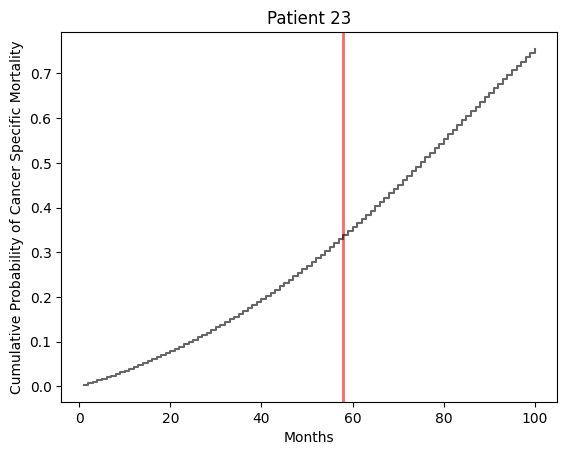

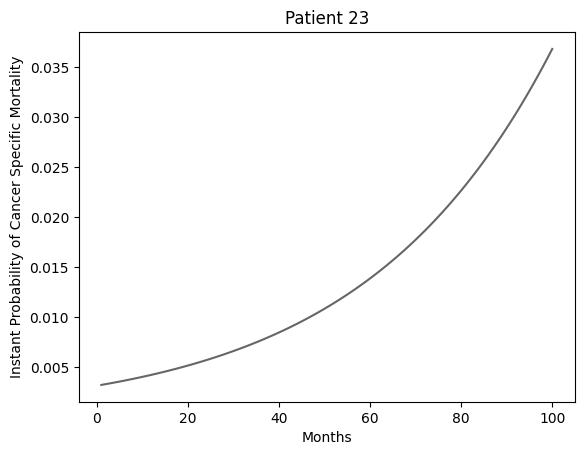

    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.991207       NaN
3      24   0.986923       NaN
4      30   0.974719  0.721154
5      36   0.978887  0.721154
6      42   0.979708  0.721154
7      48   0.979015  0.721154
8      54   0.979015  0.721154
9      60   0.972883  0.906452
10     66   0.957625  0.906452
11     72   0.934889  0.906452
12     78   0.928574  0.906452
13     84   0.928222  0.890777
14     90   0.931156  0.890777
15     96   0.930527  0.874026


In [13]:
# ONE EXPERIMENT
# At which time we'll clip out the data
max_time = 100
target_column = 'cancer_specific_mortality'
target_title = 'Cancer Specific Mortality'


# List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)
model = train_model(model=model, df_train=data_train, target_column=target_column+'_discrete',
                   max_time=max_time, x_columns_to_drop=x_columns_to_drop)

# Test on training data
data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=max_time, 
                                                 target_column=target_column)

# Test on testing data
data_test_predicted = add_predict_probabilities(data_test, model=model, max_time=max_time, 
                                                target_column=target_column)

plot_single_patient(data_test_predicted, patient_id=23, 
                    target_column=target_column, 
                    target_title=target_title, fix_axis=False)

# Discrimination Metrics
# AUC for each cumulative slice

# Months at which we'll check the AUC's
check_months = list(range(6, max_time, 6))

train_auc_stats = []
test_auc_stats = []
for w in check_months:
    # --- Training data ---
    # Selecting a subset of data based on the months
    select = (data_train_predicted['survival_time_discrete'] == w) & pd.notna(data_train_predicted[target_column+'_cumulative'])
    sub_dat = data_train_predicted[select]
    
    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    train_auc_stats.append(auc_stat)
    
    # --- Testing data ---
    # Selecting a subset of data based on the months
    select = (data_test_predicted['survival_time_discrete'] == w) & pd.notna(data_test_predicted[target_column+'_cumulative'])
    sub_dat = data_test_predicted[select]
    
    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    test_auc_stats.append(auc_stat)
    
auc_stats = pd.DataFrame(zip(check_months, train_auc_stats, test_auc_stats),
                         columns=['month', 'train_auc', 'test_auc'])
print(auc_stats)   


In [216]:
w = 100

select = (data_test_exploded['survival_time_discrete'] == w) & pd.notna(data_test_exploded['cancer_specific_mortality_cumulative'])
sub_dat = data_test_exploded[select]
fpr, tpr, thresholds = metrics.roc_curve(sub_dat['cancer_specific_mortality_cumulative'], sub_dat['CumHazard'])
auc_stat = metrics.auc(fpr, tpr)
print(f'fpr: {fpr} \n tpr: {tpr} \n thresholds: {thresholds} \n auc: {auc_stat} \n') 


fpr: [0.         0.00324675 0.00324675 0.15909091 0.15909091 0.19480519
 0.19480519 0.26948052 0.26948052 1.        ] 
 tpr: [0.  0.  0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ] 
 thresholds: [1.87187606e+00 8.71876061e-01 7.54734109e-01 3.35485950e-02
 3.27204372e-02 2.50409363e-02 2.39744160e-02 1.80712101e-02
 1.79000137e-02 6.80889266e-04] 
 auc: 0.874025974025974 



In [221]:
print(sub_dat.shape)
print('\n',sub_dat.cancer_specific_mortality_cumulative.value_counts())
print('\n',sub_dat.cancer_specific_mortality.value_counts())
print('\n',sub_dat.cancer_specific_mortality_discrete.value_counts())
print('\n', data_test_exploded.cancer_specific_mortality_cumulative.value_counts())

(313, 53)

 0    308
1      5
Name: cancer_specific_mortality_cumulative, dtype: int64

 0    305
1      8
Name: cancer_specific_mortality, dtype: int64

 0.0    174
Name: cancer_specific_mortality_discrete, dtype: int64

 0    31119
1      181
Name: cancer_specific_mortality_cumulative, dtype: int64


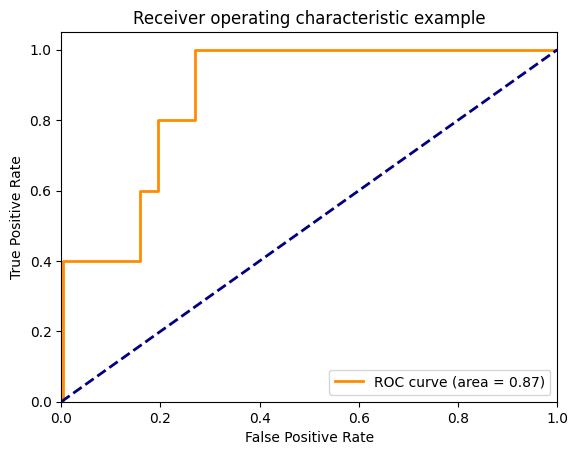

In [222]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(sub_dat['cancer_specific_mortality_cumulative'], sub_dat['CumHazard'])
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [223]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.0179000136664057


In [224]:
select = (data_test_exploded['survival_time_discrete'] == w) & pd.notna(data_test_exploded['cancer_specific_mortality_cumulative'])
sub_dat = data_test_exploded[select]
sub_X_test = sub_dat.drop(['survival_months', 'patient_id', 'bcr', 'mts',
                          'death_from_other_causes', 'cancer_specific_mortality',
                          'death_from_other_causes_discrete', 'mts_discrete',
                          'bcr_discrete', 'cancer_specific_mortality_discrete',
                             'cancer_specific_mortality_cumulative',
                             'death_from_other_causes_cumulative', 'mts_cumulative',
                             'bcr_cumulative', 'InstProb', 'CumHazard'], axis=1)
print(sub_X_test.columns)

Index(['age', 'psa', 'BxGleason', 'Rpgleson', 'clinical_stage_1',
       'clinical_stage_2', 'clinical_stage_3', 'biopsy_gleason_gg_1',
       'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3', 'biopsy_gleason_gg_4',
       'biopsy_gleason_gg_5', 'pathological_gleason_gg_1',
       'pathological_gleason_gg_2', 'pathological_gleason_gg_3',
       'pathological_gleason_gg_4', 'pathological_gleason_gg_5',
       'pathologic_stage_0', 'pathologic_stage_1', 'pathologic_stage_2',
       'lni_0.0', 'lni_1.0', 'lni_unknown', 'surgical_margin_status_0',
       'surgical_margin_status_1', 'persistent_psa_0', 'persistent_psa_1',
       'DAmico_0', 'DAmico_1', 'DAmico_2', 'DAmico_3', 'TRYSgrupes_0',
       'TRYSgrupes_1', 'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1',
       'survival_time_discrete'],
      dtype='object')


In [234]:


temp_y_pred = (model.predict_proba(sub_X_test)[:,1] >= 0.018 ).astype(int)
#temp_y_pred = model.predict_proba(X_test)[:,1]

In [235]:
pd.Series(temp_y_pred).value_counts()

0    309
1      4
dtype: int64

In [236]:
print(confusion_matrix(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred), '\n')
print(classification_report(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred, zero_division=0), '\n')
print(roc_auc_score(sub_dat.cancer_specific_mortality_cumulative, model.predict_proba(sub_X_test)[:,1]))

[[306   2]
 [  3   2]] 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       308
           1       0.50      0.40      0.44         5

    accuracy                           0.98       313
   macro avg       0.75      0.70      0.72       313
weighted avg       0.98      0.98      0.98       313
 

0.874025974025974


In [25]:
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(X_train.drop(['survival_months', 'patient_id'], axis=1), 
               X_test.drop(['survival_months', 'patient_id'], axis=1), 
               y_train.cancer_specific_mortality_discrete, 
               y_test.cancer_specific_mortality_discrete, 
               model)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/LogisticRegression"...
	Finished saving results.


In [28]:
# Example of reading experiment

model, experiment_info = read_experiment(model_name='LogisticRegression', 
                                         target_column='cancer_specific_mortality_discrete')

print(experiment_info)

{'model_name': 'LogisticRegression', 'confusion_matrix': {'train': array([[136965,      0],
       [    36,      0]], dtype=int64), 'test': array([[33142,     0],
       [   14,     0]], dtype=int64)}, 'classification_report': {'train': {'0': {'precision': 0.9997372281954147, 'recall': 1.0, 'f1-score': 0.9998685968331837, 'support': 136965}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36}, 'accuracy': 0.9997372281954147, 'macro avg': {'precision': 0.49986861409770733, 'recall': 0.5, 'f1-score': 0.49993429841659187, 'support': 137001}, 'weighted avg': {'precision': 0.9994745254398507, 'recall': 0.9997372281954147, 'f1-score': 0.9996058595576456, 'support': 137001}}, 'test': {'0': {'precision': 0.9995777536494149, 'recall': 1.0, 'f1-score': 0.9997888322423, 'support': 33142}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.9995777536494149, 'macro avg': {'precision': 0.49978887682470746, 'recall': 0.5, 'f1-score': 0.49989441612

# Propensity Score Matching

In [90]:
train = data_train
print(train.shape)
print(train.columns)

(1252, 19)
Index(['age', 'psa', 'clinical_stage', 'BxGleason', 'biopsy_gleason_gg',
       'pathological_gleason_gg', 'pathologic_stage', 'lni',
       'surgical_margin_status', 'persistent_psa', 'survival_months',
       'Rpgleson', 'TRYSgrupes', 'PLNDO1', 'patient_id', 'bcr', 'mts',
       'death_from_other_causes', 'cancer_specific_mortality'],
      dtype='object')


In [91]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [100]:
train.lni.value_counts()

unknown    763
0.0        433
1.0         56
Name: lni, dtype: int64

In [269]:
train_lni_Unknown_0 = train.copy()
train_lni_Unknown_0.reset_index(inplace=True, drop=True)
train_lni_Unknown_0 = train_lni_Unknown_0[train_lni_Unknown_0.lni != '1.0']
train_lni_Unknown_0['lni'].replace('0.0', '1', inplace=True)
train_lni_Unknown_0['lni'].replace('unknown','0', inplace=True)
print(train_lni_Unknown_0.lni.value_counts())

0    763
1    433
Name: lni, dtype: int64


In [270]:
train_lni_Unknown_0 = train_lni_Unknown_0.astype({'clinical_stage': 'int32', 
                                                  'biopsy_gleason_gg': 'int32', 
                    'pathological_gleason_gg': 'int32', 'pathologic_stage': 'int32',
                    'lni': 'int32', 'surgical_margin_status': 'int32', 
                    'persistent_psa': 'int32', 'bcr': 'int32', 'mts': 'int32', 
                    'cancer_specific_mortality': 'int32', 'death_from_other_causes': 'int32', 
                    'TRYSgrupes': 'int32', 'PLNDO1': 'int32',
                    'survival_months': 'int32'}) 

In [271]:
train_lni_Unknown_0.dtypes

age                          float64
psa                          float64
clinical_stage                 int32
BxGleason                    float64
biopsy_gleason_gg              int32
pathological_gleason_gg        int32
pathologic_stage               int32
lni                            int32
surgical_margin_status         int32
persistent_psa                 int32
survival_months                int32
Rpgleson                     float64
TRYSgrupes                     int32
PLNDO1                         int32
patient_id                     int64
bcr                            int32
mts                            int32
death_from_other_causes        int32
cancer_specific_mortality      int32
dtype: object

In [272]:
control = train_lni_Unknown_0[train_lni_Unknown_0.lni == 0]
treatment = train_lni_Unknown_0[train_lni_Unknown_0.lni == 1]

In [273]:
# student's t-test for psa (dependent variable)
from scipy.stats import ttest_ind

print(control.psa.mean(), treatment.psa.mean())

# compare samples
_, p = ttest_ind(control.psa, treatment.psa)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

6.282604193971167 11.55958429561201
p=0.000
different distributions/different group mean (reject H0)


In [274]:
# student's t-test for psa (dependent variable)
print(control.BxGleason.mean(), treatment.BxGleason.mean())

# compare samples
_, p = ttest_ind(control.BxGleason, treatment.BxGleason)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

6.335517693315858 6.74364896073903
p=0.000
different distributions/different group mean (reject H0)


In [275]:
train_lni_Unknown_0.dtypes

age                          float64
psa                          float64
clinical_stage                 int32
BxGleason                    float64
biopsy_gleason_gg              int32
pathological_gleason_gg        int32
pathologic_stage               int32
lni                            int32
surgical_margin_status         int32
persistent_psa                 int32
survival_months                int32
Rpgleson                     float64
TRYSgrupes                     int32
PLNDO1                         int32
patient_id                     int64
bcr                            int32
mts                            int32
death_from_other_causes        int32
cancer_specific_mortality      int32
dtype: object

In [276]:
# choose features for propensity score calculation
X = train_lni_Unknown_0[['age', 'psa', 'clinical_stage', 'BxGleason', 'biopsy_gleason_gg',
                         'pathological_gleason_gg', 'pathologic_stage', 'surgical_margin_status', 
                         'persistent_psa', 'Rpgleson', 'TRYSgrupes']] #'PLNDO1' , 

X = pd.get_dummies(X, columns=['clinical_stage', 'pathological_gleason_gg', 'biopsy_gleason_gg', 
                               'pathologic_stage', 'surgical_margin_status', 'persistent_psa','TRYSgrupes']) 
# 'PLNDO1' 

y = train_lni_Unknown_0['lni']

X.head()

,age,psa,BxGleason,Rpgleson,clinical_stage_1,clinical_stage_2,clinical_stage_3,pathological_gleason_gg_1,pathological_gleason_gg_2,pathological_gleason_gg_3,...,pathologic_stage_0,pathologic_stage_1,pathologic_stage_2,surgical_margin_status_0,surgical_margin_status_1,persistent_psa_0,persistent_psa_1,TRYSgrupes_0,TRYSgrupes_1,TRYSgrupes_2
0,54.0,5.10,6.0,7.0,0,1,0,0,1,0,...,1,0,0,0,1,1,0,0,1,0
1,73.0,6.88,6.0,7.0,0,1,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
2,68.0,8.40,6.0,7.0,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0
3,72.0,6.25,6.0,7.0,0,1,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0
4,66.0,10.40,7.0,7.0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1


In [277]:
# use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X, y)

LogisticRegression(max_iter=1000)

In [278]:
# combine features and coefficients into a dataframe
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
coeffs

,column,coeff
0,age,0.037957
1,psa,0.239614
2,BxGleason,-0.054696
3,Rpgleson,0.058932
4,clinical_stage_1,-0.605503
5,clinical_stage_2,-0.071337
6,clinical_stage_3,0.673420
7,pathological_gleason_gg_1,0.446649
8,pathological_gleason_gg_2,-0.535352
9,pathological_gleason_gg_3,-0.316195


In [279]:
# prediction
pred_prob = lr.predict_proba(X)  # probabilities for classes

In [280]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
train_lni_Unknown_0['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

train_lni_Unknown_0['ps_logit'] = train_lni_Unknown_0.ps.apply(lambda x: logit(x))

train_lni_Unknown_0.head()

,age,psa,clinical_stage,BxGleason,biopsy_gleason_gg,pathological_gleason_gg,pathologic_stage,lni,surgical_margin_status,persistent_psa,...,Rpgleson,TRYSgrupes,PLNDO1,patient_id,bcr,mts,death_from_other_causes,cancer_specific_mortality,ps,ps_logit
0,54.0,5.10,2,6.0,1,2,0,0,1,0,...,7.0,1,0,1189,0,0,0,0,0.108641,-2.104695
1,73.0,6.88,2,6.0,1,2,1,1,1,0,...,7.0,1,1,312,1,0,0,1,0.300660,-0.844156
2,68.0,8.40,2,6.0,1,2,0,1,0,1,...,7.0,1,1,520,1,1,0,1,0.272555,-0.981698
3,72.0,6.25,2,6.0,1,2,1,1,0,0,...,7.0,1,1,316,0,0,0,0,0.221988,-1.254118
4,66.0,10.40,3,7.0,2,2,2,1,1,0,...,7.0,2,1,125,0,0,0,0,0.752786,1.113529


<AxesSubplot: xlabel='ps', ylabel='Count'>

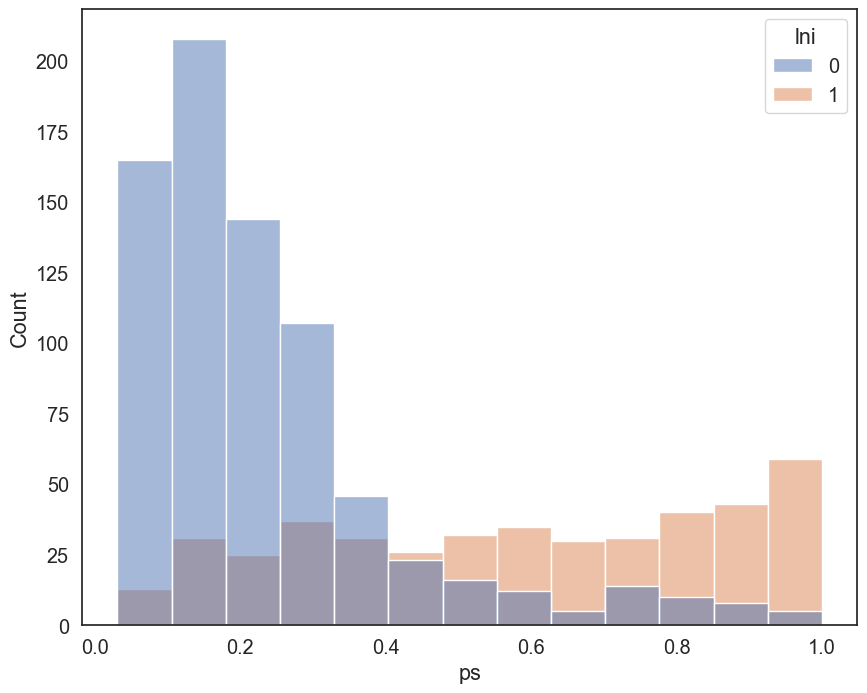

In [281]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=train_lni_Unknown_0, x='ps', hue='lni')

In [282]:
# use 25% of standard deviation of the propensity score as the caliper/radius
# get the k closest neighbors for each observations
# relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(train_lni_Unknown_0.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = train_lni_Unknown_0[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0696


NearestNeighbors(n_neighbors=10, radius=0.06962318349244027)

In [283]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

(1196, 10)
[0.00000000e+00 6.75182195e-05 2.06082356e-04 4.64250227e-04
 5.86009794e-04 5.96388075e-04 8.81964292e-04 9.95440242e-04
 1.27881181e-03 1.34582090e-03]
[   0  715  294   20  186  683  375 1006 1127  414]


In [284]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

temp = train_lni_Unknown_0.copy()
temp.reset_index(inplace=True, drop=True)

matched_control = []  # keep track of the matched observations in control

for current_index, row in temp.iterrows():  # iterate over the dataframe
    if row.lni == 0:  # the current row is in the control group
        temp.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (temp.loc[idx].lni == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    temp.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [285]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(train_lni_Unknown_0[train_lni_Unknown_0.lni==1]))
print('total matched observations in control:', len(matched_control))

total observations in treatment: 433
total matched observations in control: 220


In [286]:
# control have no match
treatment_matched = temp.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = temp.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

df_matched.lni.value_counts()

1    220
0    220
Name: lni, dtype: int64

In [287]:
# matched control and treatment
df_matched_control = df_matched[df_matched.lni==0]
df_matched_treatment = df_matched[df_matched.lni==1]

In [288]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
from scipy.stats import ttest_ind
print(df_matched_control.psa.mean(), df_matched_treatment.psa.mean())

# compare samples
_, p = ttest_ind(df_matched_control.psa, df_matched_treatment.psa)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

8.420509090909091 8.367454545454544
p=0.905
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [461]:
X = pd.get_dummies(train_lni_Unknown_0, columns=['clinical_stage', 'pathological_gleason_gg', 'biopsy_gleason_gg', 
                               'pathologic_stage', 'surgical_margin_status', 'persistent_psa','TRYSgrupes']) 

In [289]:
train_lni_Unknown_0.columns

Index(['age', 'psa', 'clinical_stage', 'BxGleason', 'biopsy_gleason_gg',
       'pathological_gleason_gg', 'pathologic_stage', 'lni',
       'surgical_margin_status', 'persistent_psa', 'survival_months',
       'Rpgleson', 'TRYSgrupes', 'PLNDO1', 'patient_id', 'bcr', 'mts',
       'death_from_other_causes', 'cancer_specific_mortality', 'ps',
       'ps_logit'],
      dtype='object')

In [462]:
# exclude: ignore any covariates (columns) passed to the it during model fitting
# indx - required parameter that references a unique ID number for each case
psm = PsmPy(X, treatment='lni', indx='patient_id', 
            exclude = ['ps_logit', 'ps', 'cancer_specific_mortality', 
                       'death_from_other_causes', 'mts', 'bcr', 'PLNDO1',
                      'survival_months'])

In [463]:
# same as my code using balance=False
psm.logistic_ps(balance=False)
psm.predicted_data

,patient_id,age,psa,BxGleason,Rpgleson,clinical_stage_1,clinical_stage_2,clinical_stage_3,pathological_gleason_gg_1,pathological_gleason_gg_2,...,surgical_margin_status_0,surgical_margin_status_1,persistent_psa_0,persistent_psa_1,TRYSgrupes_0,TRYSgrupes_1,TRYSgrupes_2,propensity_score,propensity_logit,lni
0,1189,54.0,5.10,6.0,7.0,0,1,0,0,1,...,0,1,1,0,0,1,0,0.111450,-2.076015,0
1,1289,60.0,3.01,7.0,7.0,0,1,0,0,0,...,1,0,0,1,0,1,0,0.177267,-1.534976,0
2,1527,64.0,6.00,6.0,6.0,1,0,0,1,0,...,1,0,1,0,1,0,0,0.131862,-1.884592,0
3,986,64.0,8.60,7.0,7.0,0,0,1,0,1,...,1,0,1,0,0,1,0,0.580045,0.322957,0
4,1448,56.0,1.42,6.0,6.0,0,1,0,1,0,...,1,0,1,0,1,0,0,0.061836,-2.719446,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,92,69.0,7.40,7.0,9.0,0,0,1,0,0,...,0,1,1,0,0,0,1,0.804426,1.414191,1
1192,504,70.0,8.92,6.0,6.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0.615878,0.472088,1
1193,491,66.0,5.92,8.0,7.0,0,0,1,0,0,...,1,0,1,0,0,1,0,0.900754,2.205634,1
1194,204,60.0,46.16,7.0,7.0,0,0,1,0,1,...,0,1,0,1,0,0,1,0.999825,8.652082,1


In [464]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=0.2)

C:\Users\Vytautas\AppData\Local\Programs\Python\Python310\lib\site-packages\psmpy\psmpy.py:346: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


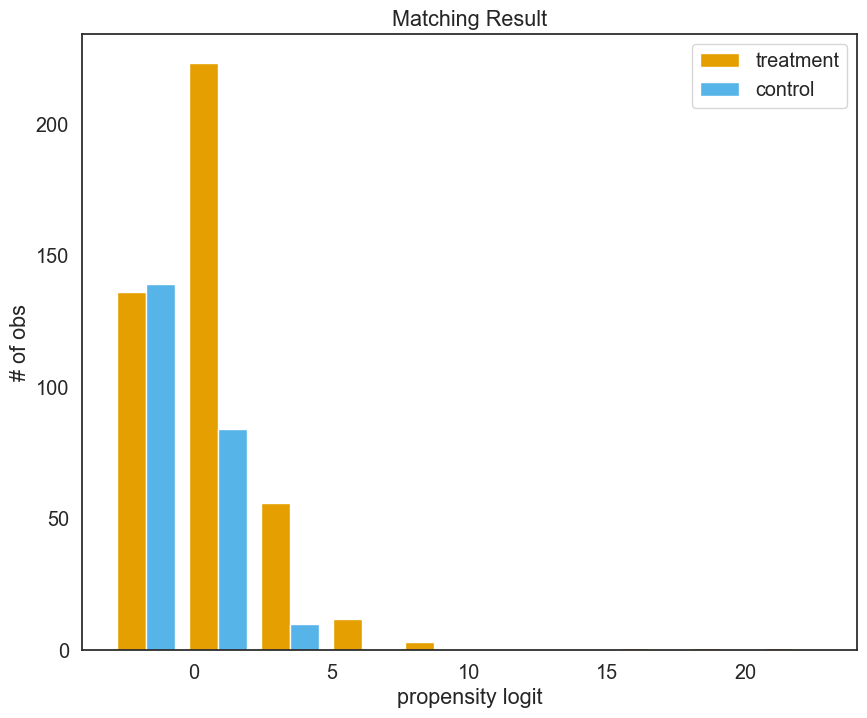

In [465]:
psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])

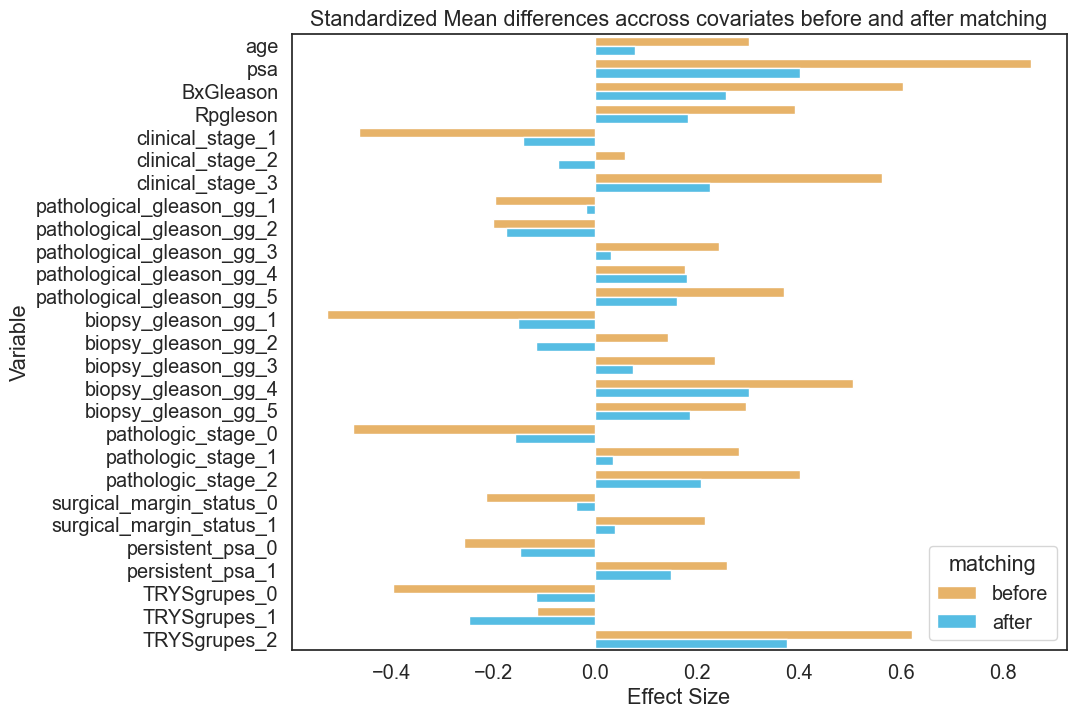

In [466]:
psm.effect_size_plot()

In [467]:
psm.matched_ids

,patient_id,matched_ID
0,312,1297.0
1,520,881.0
2,316,1347.0
3,125,1205.0
4,173,1049.0
...,...,...
428,92,NaN
429,504,NaN
430,491,NaN
431,204,NaN


In [468]:
matched_ids = psm.matched_ids[~np.isnan(psm.matched_ids.matched_ID)]
all_ids = pd.concat([matched_ids.patient_id, matched_ids.matched_ID]).values

In [469]:
df_matched = psm.df_matched.query('patient_id in @all_ids')

In [470]:
df_matched

,patient_id,age,psa,BxGleason,Rpgleson,clinical_stage_1,clinical_stage_2,clinical_stage_3,pathological_gleason_gg_1,pathological_gleason_gg_2,...,surgical_margin_status_0,surgical_margin_status_1,persistent_psa_0,persistent_psa_1,TRYSgrupes_0,TRYSgrupes_1,TRYSgrupes_2,propensity_score,propensity_logit,lni
0,312,73.0,6.88,6.0,7.0,0,1,0,0,1,...,0,1,1,0,0,1,0,0.297344,-0.859978,1
1,520,68.0,8.40,6.0,7.0,0,1,0,0,1,...,1,0,0,1,0,1,0,0.268952,-0.999948,1
2,316,72.0,6.25,6.0,7.0,0,1,0,0,1,...,1,0,1,0,0,1,0,0.219360,-1.269397,1
3,125,66.0,10.40,7.0,7.0,0,0,1,0,1,...,0,1,1,0,0,0,1,0.758289,1.143321,1
4,173,71.0,5.20,7.0,9.0,0,1,0,0,0,...,0,1,0,1,0,0,1,0.372071,-0.523341,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,952,64.0,4.07,6.0,7.0,0,1,0,0,1,...,0,1,1,0,0,1,0,0.136306,-1.846316,0
662,1229,63.0,7.80,6.0,7.0,1,0,0,0,1,...,0,1,1,0,0,1,0,0.161025,-1.650620,0
663,1001,72.0,5.38,6.0,7.0,0,1,0,0,1,...,1,0,1,0,0,1,0,0.169064,-1.592278,0
664,992,62.0,4.00,6.0,7.0,0,0,1,0,1,...,1,0,1,0,0,1,0,0.195448,-1.414988,0


In [471]:
print('Before:\n', train_lni_Unknown_0.lni.value_counts())
print('\nAfter:\n', df_matched.lni.value_counts())


Before:
 0    763
1    433
Name: lni, dtype: int64

After:
 1    233
0    233
Name: lni, dtype: int64


In [472]:
# matched control and treatment
df_matched_control = df_matched[df_matched.lni==0]
df_matched_treatment = df_matched[df_matched.lni==1]

In [473]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
from scipy.stats import ttest_ind
print(df_matched_control.psa.mean(), df_matched_treatment.psa.mean())

# compare samples
_, p = ttest_ind(df_matched_control.psa, df_matched_treatment.psa)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

8.344163090128756 8.467768240343348
p=0.774
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [492]:
temp = train.copy()
temp = pd.get_dummies(temp, columns=['clinical_stage', 'pathological_gleason_gg', 'biopsy_gleason_gg', 
                               'pathologic_stage', 'surgical_margin_status', 'persistent_psa','TRYSgrupes']) 
temp = temp[temp.lni == '1.0']
temp['lni'].replace('1.0', '1', inplace=True)
temp = temp.astype({'lni': 'int32'})


train_lni_Unknown0_1 = df_matched.copy()
train_lni_Unknown0_1 = train_lni_Unknown0_1.drop(['propensity_score', 'propensity_logit'], axis=1)
train_lni_Unknown0_1.reset_index(inplace=True, drop=True)
train_lni_Unknown0_1['lni'].replace(1, 0, inplace=True)
train_lni_Unknown0_1 = pd.concat([train_lni_Unknown0_1, temp])
train_lni_Unknown0_1 = train_lni_Unknown0_1.drop(['PLNDO1', 'bcr', 'mts',
                                                 'death_from_other_causes',
                                                 'cancer_specific_mortality'], axis=1)
print(train_lni_Unknown0_1.lni.value_counts())

0    466
1     56
Name: lni, dtype: int64


In [493]:
train_lni_Unknown0_1.dtypes

patient_id                     int64
age                          float64
psa                          float64
BxGleason                    float64
Rpgleson                     float64
clinical_stage_1               uint8
clinical_stage_2               uint8
clinical_stage_3               uint8
pathological_gleason_gg_1      uint8
pathological_gleason_gg_2      uint8
pathological_gleason_gg_3      uint8
pathological_gleason_gg_4      uint8
pathological_gleason_gg_5      uint8
biopsy_gleason_gg_1            uint8
biopsy_gleason_gg_2            uint8
biopsy_gleason_gg_3            uint8
biopsy_gleason_gg_4            uint8
biopsy_gleason_gg_5            uint8
pathologic_stage_0             uint8
pathologic_stage_1             uint8
pathologic_stage_2             uint8
surgical_margin_status_0       uint8
surgical_margin_status_1       uint8
persistent_psa_0               uint8
persistent_psa_1               uint8
TRYSgrupes_0                   uint8
TRYSgrupes_1                   uint8
T

In [553]:
# exclude: ignore any covariates (columns) passed to the it during model fitting
# indx - required parameter that references a unique ID number for each case
psm = PsmPy(train_lni_Unknown0_1, treatment='lni', indx='patient_id', 
            exclude = ['survival_months'])

In [554]:
# same as my code using balance=False
psm.logistic_ps(balance=False)
psm.predicted_data

,patient_id,age,psa,BxGleason,Rpgleson,clinical_stage_1,clinical_stage_2,clinical_stage_3,pathological_gleason_gg_1,pathological_gleason_gg_2,...,surgical_margin_status_0,surgical_margin_status_1,persistent_psa_0,persistent_psa_1,TRYSgrupes_0,TRYSgrupes_1,TRYSgrupes_2,propensity_score,propensity_logit,lni
0,312,73.0,6.88,6.0,7.0,0,1,0,0,1,...,0,1,1,0,0,1,0,0.000445,-7.716705,0
1,520,68.0,8.40,6.0,7.0,0,1,0,0,1,...,1,0,0,1,0,1,0,0.003740,-5.584970,0
2,316,72.0,6.25,6.0,7.0,0,1,0,0,1,...,1,0,1,0,0,1,0,0.000759,-7.183008,0
3,125,66.0,10.40,7.0,7.0,0,0,1,0,1,...,0,1,1,0,0,0,1,0.218143,-1.276523,0
4,173,71.0,5.20,7.0,9.0,0,1,0,0,0,...,0,1,0,1,0,0,1,0.101241,-2.183510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,37,60.0,15.70,9.0,10.0,0,0,1,0,0,...,0,1,0,1,0,0,1,0.946023,2.863704,1
518,60,59.0,13.38,7.0,7.0,0,1,0,0,0,...,1,0,1,0,0,0,1,0.139611,-1.818522,1
519,3,65.0,7.60,7.0,7.0,0,0,1,0,1,...,1,0,0,1,0,0,1,0.622101,0.498476,1
520,13,54.0,6.50,7.0,7.0,0,1,0,0,0,...,1,0,1,0,0,0,1,0.286227,-0.913781,1


In [555]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=5)

C:\Users\Vytautas\AppData\Local\Programs\Python\Python310\lib\site-packages\psmpy\psmpy.py:346: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


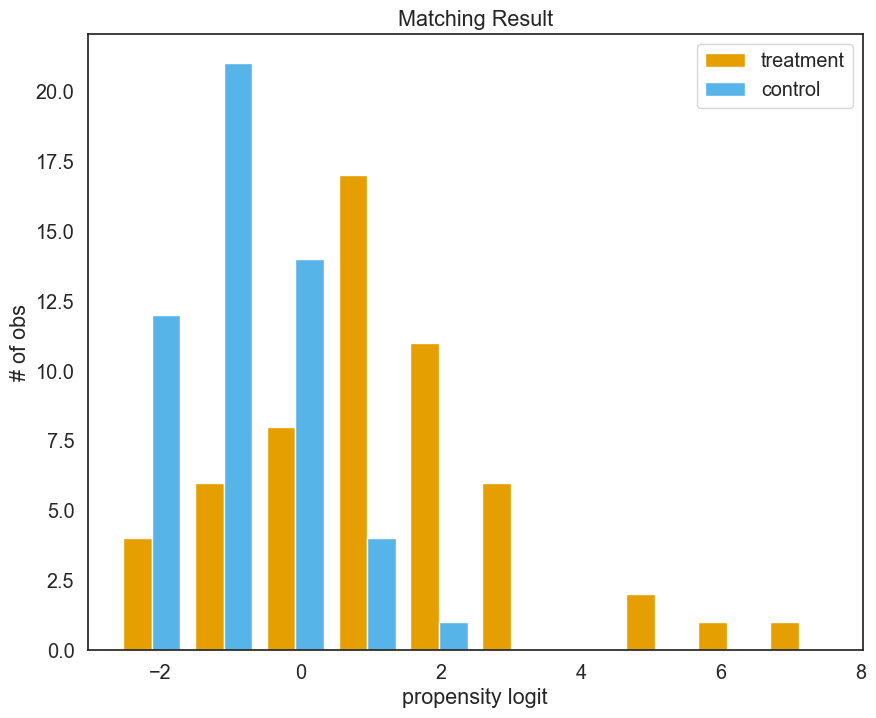

In [556]:
psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])

C:\Users\Vytautas\AppData\Local\Programs\Python\Python310\lib\site-packages\psmpy\functions.py:25: RuntimeWarning: invalid value encountered in double_scalars
  d = (treated_metric.mean() - untreated_metric.mean()) / math.sqrt(((treated_metric.count()-1)*treated_metric.std() **


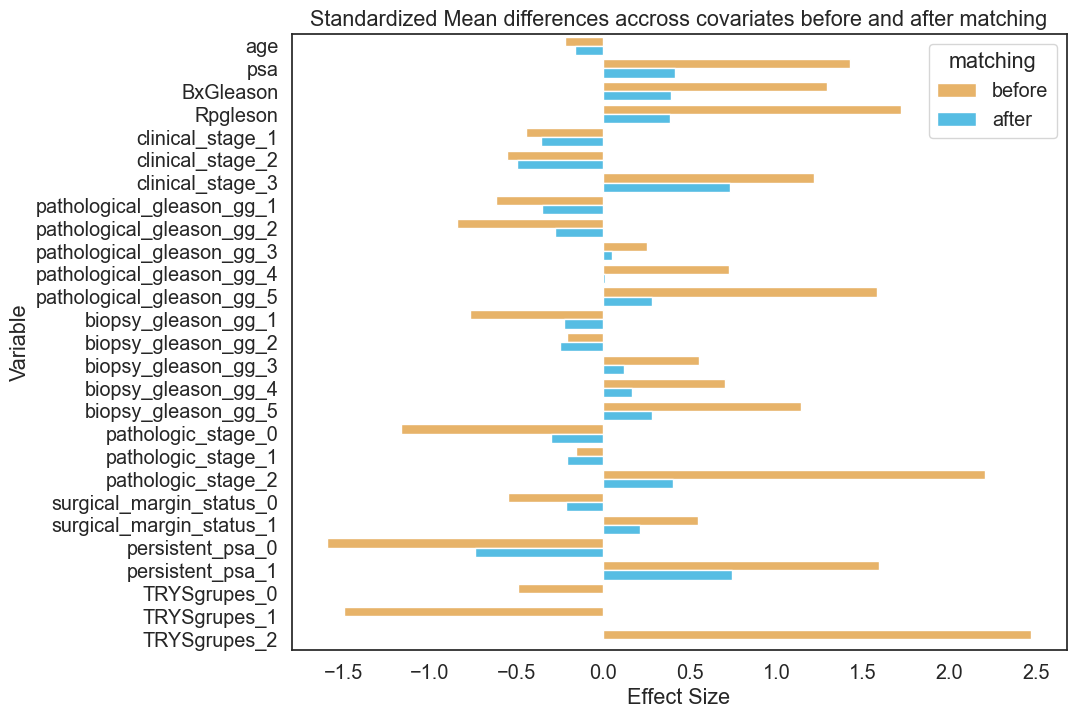

In [557]:
psm.effect_size_plot()

In [558]:
matched_ids = psm.matched_ids[~np.isnan(psm.matched_ids.matched_ID)]
all_ids = pd.concat([matched_ids.patient_id, matched_ids.matched_ID]).values

In [559]:
df_matched = psm.df_matched.query('patient_id in @all_ids')

In [560]:
df_matched

,patient_id,age,psa,BxGleason,Rpgleson,clinical_stage_1,clinical_stage_2,clinical_stage_3,pathological_gleason_gg_1,pathological_gleason_gg_2,...,surgical_margin_status_0,surgical_margin_status_1,persistent_psa_0,persistent_psa_1,TRYSgrupes_0,TRYSgrupes_1,TRYSgrupes_2,propensity_score,propensity_logit,lni
0,65,63.0,11.33,6.0,7.0,0,0,1,0,1,...,0,1,0,1,0,0,1,0.281852,-0.935296,1
1,21,69.0,13.80,6.0,7.0,1,0,0,0,1,...,0,1,0,1,0,0,1,0.160785,-1.652398,1
2,35,62.0,12.00,6.0,9.0,0,0,1,0,0,...,0,1,0,1,0,0,1,0.625641,0.513562,1
3,51,56.0,12.44,7.0,9.0,0,1,0,0,0,...,0,1,0,1,0,0,1,0.620552,0.491893,1
4,64,68.0,13.17,8.0,7.0,0,0,1,0,0,...,0,1,0,1,0,0,1,0.663868,0.680580,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,630,59.0,25.70,6.0,7.0,1,0,0,0,1,...,1,0,1,0,0,0,1,0.134251,-1.863880,0
104,72,60.0,13.39,5.0,7.0,0,1,0,0,1,...,1,0,1,0,0,0,1,0.131023,-1.891947,0
105,101,70.0,11.90,6.0,8.0,0,1,0,0,0,...,0,1,1,0,0,0,1,0.114410,-2.046463,0
106,604,70.0,7.17,7.0,7.0,0,1,0,0,0,...,1,0,1,0,0,0,1,0.113073,-2.059733,0


In [561]:
print('Before:\n', train_lni_Unknown0_1.lni.value_counts())
print('\nAfter:\n', df_matched.lni.value_counts())


Before:
 0    466
1     56
Name: lni, dtype: int64

After:
 1    52
0    52
Name: lni, dtype: int64


In [562]:
# matched control and treatment
df_matched_control = df_matched[df_matched.lni==0]
df_matched_treatment = df_matched[df_matched.lni==1]

In [563]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
from scipy.stats import ttest_ind
print(df_matched_control.psa.mean(), df_matched_treatment.psa.mean())

# compare samples
_, p = ttest_ind(df_matched_control.psa, df_matched_treatment.psa)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

12.390384615384615 14.362115384615386
p=0.234
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [567]:
all_ids_matched = df_matched.patient_id

df_matched_original = data_train.query('patient_id in @all_ids_matched')

In [573]:
# -------------------------
# csm
# -------------------------
columns = df_matched_original.columns.tolist()
columns_to_remove = ['patient_id']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'cancer_specific_mortality'

mytable = TableOne(df_matched_original, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')

|                                  |         | Overall           | 0                 | 1                |
|----------------------------------|---------|-------------------|-------------------|------------------|
| n                                |         | 104               | 88                | 16               |
| Age (years), median [min,max]    |         | 64.0 [46.0,76.0]  | 63.0 [46.0,76.0]  | 65.5 [54.0,72.0] |
| psa, median [Q1,Q3]              |         | 10.7 [7.3,19.0]   | 11.0 [7.4,20.1]   | 8.6 [5.5,12.0]   |
| clinical_stage, n (%)            | 1       | 9 (8.7)           | 9 (10.2)          |                  |
|                                  | 2       | 55 (52.9)         | 49 (55.7)         | 6 (37.5)         |
|                                  | 3       | 40 (38.5)         | 30 (34.1)         | 10 (62.5)        |
| BxGleason, median [Q1,Q3]        |         | 7.0 [7.0,8.0]     | 7.0 [7.0,8.0]     | 7.5 [7.0,8.0]    |
| biopsy_gleason_gg, n (%)         | 1       |

In [575]:
# Create dummy variables for categorical data
data_train_temp = pd.get_dummies(df_matched_original, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])
data_test_temp = pd.get_dummies(data_test, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])

In [582]:
print('Shape of train: ', data_train_temp.shape, '\n')
print('Shape of test: ', data_test_temp.shape, '\n')

Shape of train:  (104, 36) 

Shape of test:  (313, 36) 



In [581]:
data_train_temp = data_train_temp.drop(['TRYSgrupes_2'], axis=1)
data_test_temp = data_test_temp.drop(['TRYSgrupes_0','TRYSgrupes_1','TRYSgrupes_2'], axis=1)

In [583]:
# Check min and max survival times
print(f'Max training survival months - {data_train_temp["survival_months"].max()}')
print(f'Min training survival months - {data_train_temp["survival_months"].min()}')

Max training survival months - 212
Min training survival months - 1


In [584]:
# Define the model
model = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=3)

# Run the experiment
run_experiment(df_train=data_train_temp, df_test=data_test_temp, model=model, 
               max_time=200, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('RandomForestClassifier', 'cancer_specific_mortality', 200)

print(auc_stats)

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/200/RandomForestClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.970874       NaN
3      24   0.990196       NaN
4      30   0.993399  0.964744
5      36   0.997500  0.961538
6      42   0.973490  0.961538
7      48   0.976562  0.894231
8      54   0.975260  0.900641
9      60   0.981287  0.896774
10     66   0.986170  0.896774
11     72   0.986170  0.896774
12     78   0.982405  0.897849
13     84   0.982405  0.902104
14     90   0.980072  0.902104
15     96   0.961116  0.753896
16    102   0.959425  0.753247
17    108   0.946825  0.761129
18    114   0.946825  0.760586
19    120   0.947619  0.760043
20    126   0.947619  0.775444
21    132   0.939326  0.773576
22    138   0.938577  0.679098
23    144   0.938577  0.67